# [**Comparaison entre la recherche en grille et le "Successive Halving"**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/3_model_selection/plot_successive_halving_heatmap.ipynb)<br/>([_Comparison between grid search and successive halving_](https://scikit-learn.org/stable/auto_examples/model_selection/plot_successive_halving_heatmap.html))

Cet exemple compare la recherche de paramètres effectuée par [**`HalvingGridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) et [**`GridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [1]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

Tout d'abord, nous définissons l'espace des paramètres pour un estimateur [**`SVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) et calculons le temps nécessaire pour entraîner une instance de [**`HalvingGridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html), ainsi qu'une instance de [**`GridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [2]:
rng = np.random.RandomState(0)
X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)
gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

Ensuite, nous traçons des cartes de chaleur (heatmaps) pour les deux estimateurs de recherche.

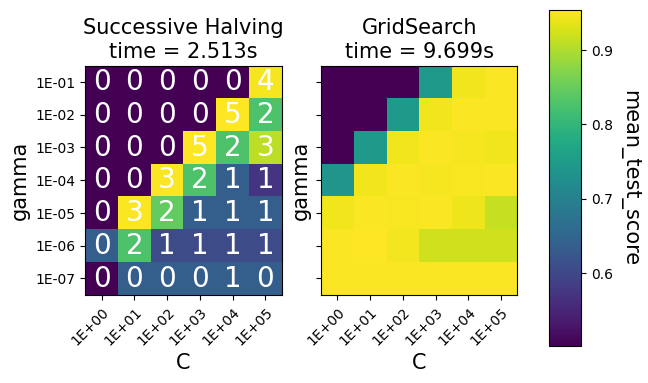

In [3]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

Les cartes de chaleur montrent le score moyen des combinaisons de paramètres pour une instance de [**`SVC`**](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html). [**`HalvingGridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) montre également l'itération à laquelle les combinaisons ont été utilisées pour la dernière fois. Les combinaisons marquées comme `0` ont été évaluées uniquement lors de la première itération, tandis que celles avec `5` sont les combinaisons de paramètres considérées comme les meilleures.

Nous pouvons voir que la classe [**`HalvingGridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingGridSearchCV.html) est capable de trouver des combinaisons de paramètres aussi précises que [**`GridSearchCV`**](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), en beaucoup moins de temps.